In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
from collections import Counter, defaultdict
import math
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

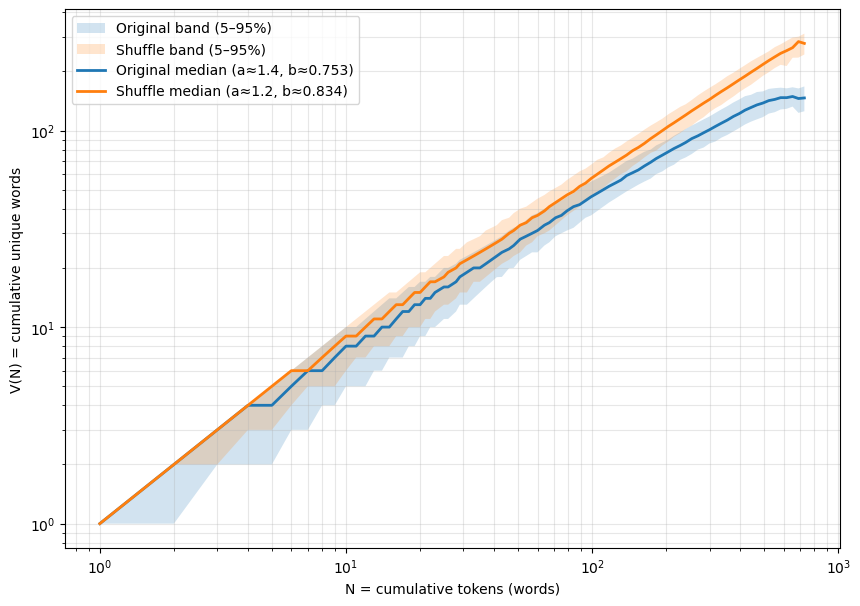

In [6]:
# ----------------------------
# CONFIG
# ----------------------------
WORDS_COL = "words"

ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Premier_League_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "Premier_League_24_25_full_shuffle"

# punti su cui valutare V(N) (log-spaced) -> evita "tantissime linee"
N_POINTS = 120

# band: 5-95% (più chiaro). Se vuoi 25-75% metti (25, 75)
BAND = (5, 95)

# ignora match troppo corti (se vuoi). 0 = non filtrare
MIN_TOKENS = 0


# ----------------------------
# Helpers
# ----------------------------
def read_tokens(csv_path: Path, col=WORDS_COL) -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except Exception:
            return np.array([], dtype=object)

    if col not in df.columns:
        return np.array([], dtype=object)

    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()


def heaps_curve(tokens: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Return N (1..T) and V(N) for a single text.
    tokens: sequence of WORD tokens (strings)
    """
    seen = set()
    V = np.empty(len(tokens), dtype=int)
    v = 0
    for i, t in enumerate(tokens):
        if t not in seen:
            seen.add(t)
            v += 1
        V[i] = v
    N = np.arange(1, len(tokens) + 1)
    return N, V


def sample_curve_on_grid(N: np.ndarray, V: np.ndarray, grid: np.ndarray) -> np.ndarray:
    """
    Interpolate V(N) on a global grid of N values.
    We use np.interp, so we need N increasing (it is).
    Values beyond last N are set to NaN (so they don't affect aggregation).
    """
    out = np.full(grid.shape, np.nan, dtype=float)
    maxN = N[-1]
    mask = grid <= maxN
    out[mask] = np.interp(grid[mask], N, V).astype(float)
    return out


def build_aggregate_V_matrix(folder: Path, grid: np.ndarray) -> np.ndarray:
    files = sorted([p for p in folder.iterdir() if p.is_file() and p.suffix.lower() == ".csv"])
    curves = []
    for p in files:
        tokens = read_tokens(p, col=WORDS_COL)
        if len(tokens) == 0 or len(tokens) < MIN_TOKENS:
            continue
        N, V = heaps_curve(tokens)
        curves.append(sample_curve_on_grid(N, V, grid))
    if len(curves) == 0:
        return np.empty((0, len(grid)), dtype=float)
    return np.vstack(curves)


def fit_heaps_powerlaw(N: np.ndarray, V: np.ndarray):
    """
    Fit log V = log a + b log N on points where both are finite and >0.
    Returns a, b.
    """
    m = np.isfinite(N) & np.isfinite(V) & (N > 0) & (V > 0)
    x = np.log(N[m])
    y = np.log(V[m])
    if len(x) < 10:
        return np.nan, np.nan
    b, loga = np.polyfit(x, y, 1)
    a = np.exp(loga)
    return a, b


# ----------------------------
# Global grid for N (log-spaced)
# ----------------------------
# Use max tokens across BOTH corpora to define the grid
def max_tokens_in_dir(folder: Path) -> int:
    mx = 0
    for p in folder.iterdir():
        if p.is_file() and p.suffix.lower() == ".csv":
            t = read_tokens(p, col=WORDS_COL)
            if len(t) > mx:
                mx = len(t)
    return mx

maxN = max(max_tokens_in_dir(ORIG_DIR), max_tokens_in_dir(SHUF_DIR))
if maxN <= 1:
    raise RuntimeError("Non trovo abbastanza token nei file per costruire Heaps.")

grid = np.unique(np.round(np.logspace(0, np.log10(maxN), N_POINTS)).astype(int))
grid = grid[grid >= 1]

# ----------------------------
# Build matrices: rows = matches, cols = grid points
# ----------------------------
V_orig = build_aggregate_V_matrix(ORIG_DIR, grid)
V_shuf = build_aggregate_V_matrix(SHUF_DIR, grid)

# Aggregate: median line + band
def summarize(Vmat: np.ndarray):
    med = np.nanmedian(Vmat, axis=0)
    lo = np.nanpercentile(Vmat, BAND[0], axis=0)
    hi = np.nanpercentile(Vmat, BAND[1], axis=0)
    return med, lo, hi

med_o, lo_o, hi_o = summarize(V_orig)
med_s, lo_s, hi_s = summarize(V_shuf)

# Fit Heaps on the median curves (optional, but handy to report a,b)
a_o, b_o = fit_heaps_powerlaw(grid.astype(float), med_o)
a_s, b_s = fit_heaps_powerlaw(grid.astype(float), med_s)

# ----------------------------
# Plot: one line per corpus + band
# ----------------------------
plt.figure(figsize=(10, 7))

# bands
plt.fill_between(grid, lo_o, hi_o, alpha=0.2, label=f"Original band ({BAND[0]}–{BAND[1]}%)")
plt.fill_between(grid, lo_s, hi_s, alpha=0.2, label=f"Shuffle band ({BAND[0]}–{BAND[1]}%)")

# median lines
plt.plot(grid, med_o, linewidth=2, label=f"Original median (a≈{a_o:.2g}, b≈{b_o:.3f})")
plt.plot(grid, med_s, linewidth=2, label=f"Shuffle median (a≈{a_s:.2g}, b≈{b_s:.3f})")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("N = cumulative tokens (words)")
plt.ylabel("V(N) = cumulative unique words")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()

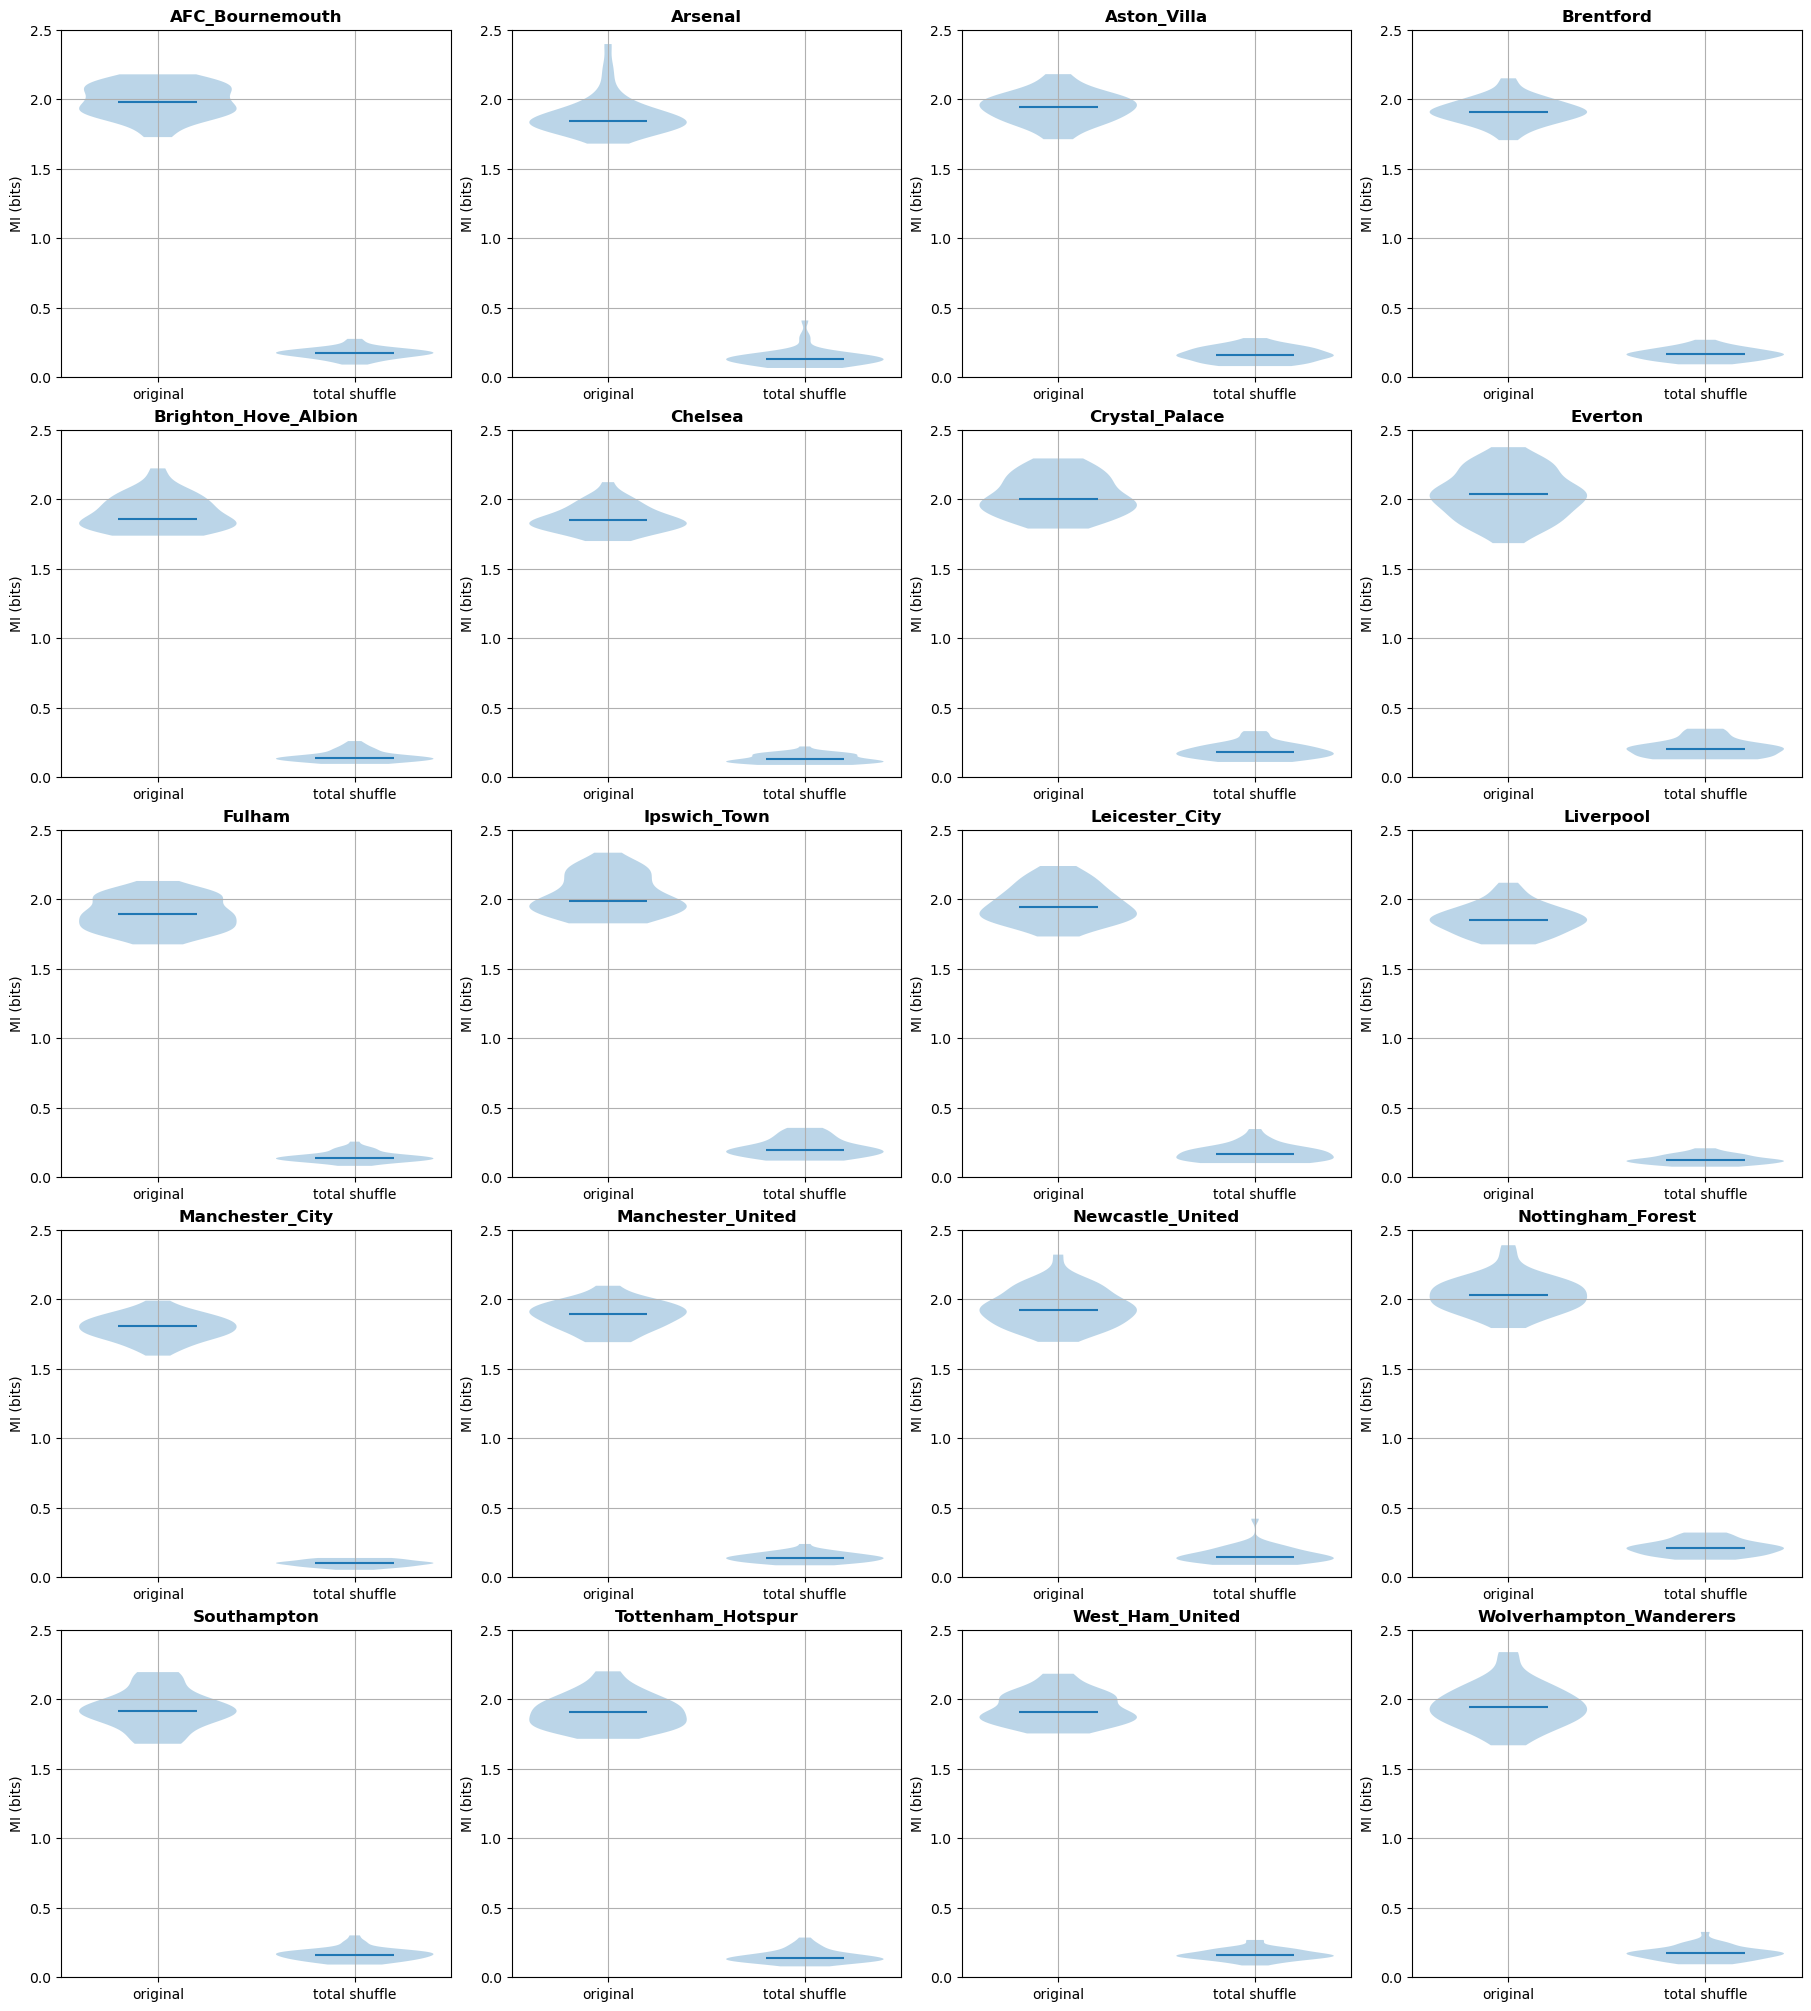

In [2]:
# ----------------------------
# CONFIG
# ----------------------------
# ----------------------------
# CONFIG
# ----------------------------
file_list = [
    "AFC_Bournemouth.csv",
    "Arsenal.csv",
    "Aston_Villa.csv",
    "Brentford.csv",
    "Brighton_Hove_Albion.csv",
    "Chelsea.csv",
    "Crystal_Palace.csv",
    "Everton.csv",
    "Fulham.csv",
    "Ipswich_Town.csv",
    "Leicester_City.csv",
    "Liverpool.csv",
    "Manchester_City.csv",
    "Manchester_United.csv",
    "Newcastle_United.csv",
    "Nottingham_Forest.csv",
    "Southampton.csv",
    "Tottenham_Hotspur.csv",
    "West_Ham_United.csv",
    "Wolverhampton_Wanderers.csv",
]

TEAM_PREFIXES = [Path(x).stem for x in file_list]
WORDS_COL = "words"
SEP = "-"

# Percorsi (Assicurati che siano corretti per il tuo ambiente)
ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Premier_League_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "Premier_League_24_25_full_shuffle"

# ----------------------------
# MI helpers
# ----------------------------
def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_bigrams_from_words(words: np.ndarray, sep: str = "-"):
    bigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 1):
            bigrams.append((ph[i], ph[i + 1]))
    return unigrams, bigrams

def mutual_information_adjacent(unigrams, bigrams):
    if len(bigrams) == 0:
        return np.nan
    uni = Counter(unigrams)
    bi = Counter(bigrams)
    total_u = sum(uni.values())
    total_b = sum(bi.values())
    p = {k: v / total_u for k, v in uni.items()}
    mi = 0.0
    for (x, y), c in bi.items():
        pxy = c / total_b
        mi += pxy * math.log2(pxy / (p[x] * p[y]))
    return mi

def read_words_column(csv_path: Path, col="words") -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except:
            return np.array([], dtype=object)
    if col not in df.columns:
        return np.array([], dtype=object)
    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def mi_for_match_file(csv_path: Path) -> float:
    words = read_words_column(csv_path, col=WORDS_COL)
    if len(words) == 0:
        return np.nan
    unigrams, bigrams = flatten_bigrams_from_words(words, sep=SEP)
    return mutual_information_adjacent(unigrams, bigrams)

# ----------------------------
# Raccolta dati e calcolo limiti globali
# ----------------------------
orig_files = [p for p in ORIG_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".csv"] if ORIG_DIR.exists() else []
team_to_vals = {team: {"original": [], "total shuffle": []} for team in TEAM_PREFIXES}

all_mi_values = []

for team in TEAM_PREFIXES:
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]
    for p in team_files:
        shuf_p = SHUF_DIR / p.name
        if not shuf_p.exists(): continue
        
        mi_o = mi_for_match_file(p)
        mi_s = mi_for_match_file(shuf_p)
        
        if not np.isnan(mi_o):
            team_to_vals[team]["original"].append(mi_o)
            all_mi_values.append(mi_o)
        if not np.isnan(mi_s):
            team_to_vals[team]["total shuffle"].append(mi_s)
            all_mi_values.append(mi_s)

# Calcolo limiti per asse Y comune
if all_mi_values:
    y_min = math.floor(min(all_mi_values) * 2) / 2  # Arrotonda per difetto allo 0.5 più vicino
    y_max = math.ceil(max(all_mi_values) * 2) / 2   # Arrotonda per eccesso allo 0.5 più vicino
else:
    y_min, y_max = 0, 5

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(18, 20), constrained_layout=True)
axes = axes.ravel()

for i, team in enumerate(TEAM_PREFIXES):
    ax = axes[i]
    orig_vals = np.array(team_to_vals[team]["original"], dtype=float)
    shuf_vals = np.array(team_to_vals[team]["total shuffle"], dtype=float)
    
    orig_vals = orig_vals[np.isfinite(orig_vals)]
    shuf_vals = shuf_vals[np.isfinite(shuf_vals)]
    
    if len(orig_vals) > 0 and len(shuf_vals) > 0:
        parts = ax.violinplot([orig_vals, shuf_vals], positions=[1, 2], 
                               widths=0.8, showmedians=True, showextrema=False)
    
    # --- UNIFORMITÀ SCALA ---
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    # ------------------------

    ax.set_title(f"{team}", fontweight="bold")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["original", "total shuffle"])
    ax.set_ylabel("MI (bits)")
    ax.grid()

    if len(orig_vals) == 0:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center")

for j in range(len(TEAM_PREFIXES), len(axes)):
    axes[j].axis("off")

plt.show()

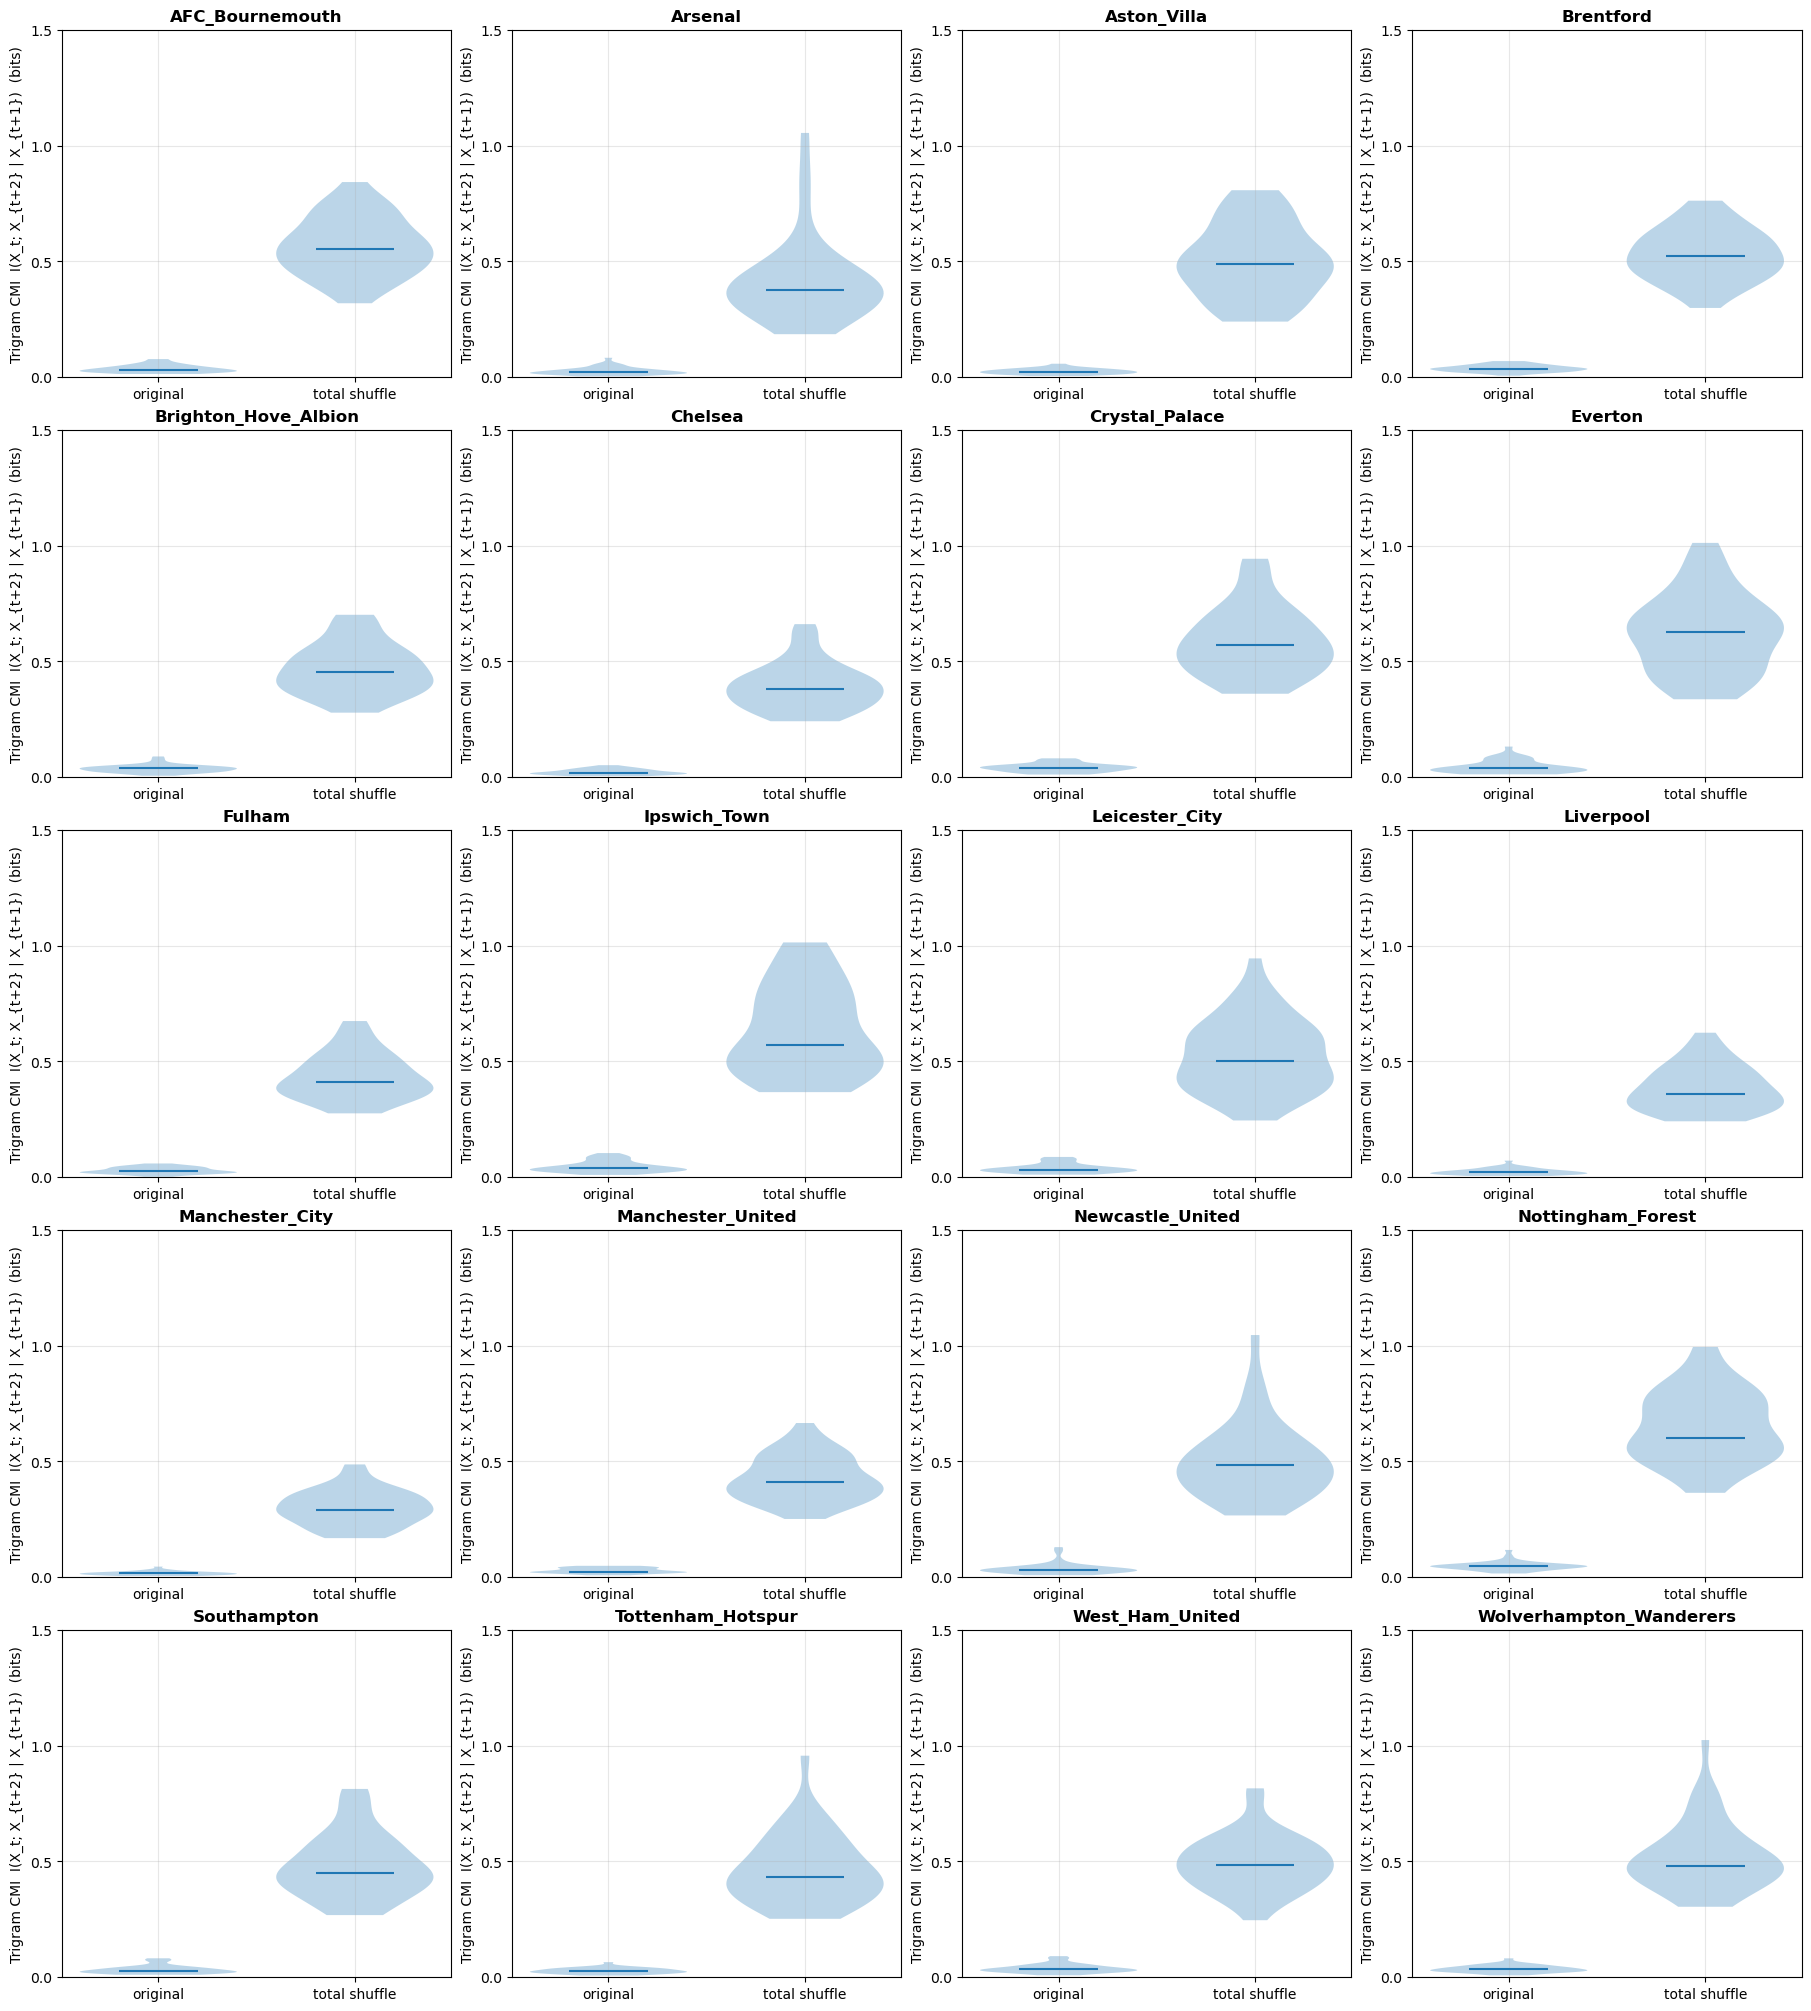

In [3]:
# ----------------------------
# CONFIG
# ----------------------------
# ----------------------------
# CONFIG
# ----------------------------
file_list = [
    "AFC_Bournemouth.csv",
    "Arsenal.csv",
    "Aston_Villa.csv",
    "Brentford.csv",
    "Brighton_Hove_Albion.csv",
    "Chelsea.csv",
    "Crystal_Palace.csv",
    "Everton.csv",
    "Fulham.csv",
    "Ipswich_Town.csv",
    "Leicester_City.csv",
    "Liverpool.csv",
    "Manchester_City.csv",
    "Manchester_United.csv",
    "Newcastle_United.csv",
    "Nottingham_Forest.csv",
    "Southampton.csv",
    "Tottenham_Hotspur.csv",
    "West_Ham_United.csv",
    "Wolverhampton_Wanderers.csv",
]

TEAM_PREFIXES = [Path(x).stem for x in file_list]
WORDS_COL = "words"
SEP = "-"

# Percorsi (Assicurati che siano corretti per il tuo ambiente)
ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Premier_League_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "Premier_League_24_25_full_shuffle"

# ----------------------------
# Tokenization
# ----------------------------
def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_trigrams_from_words(words: np.ndarray, sep: str = "-"):
    """
    Return:
      - unigrams list
      - trigrams list of (x, y, z) representing x->y->z within each word
    Words with <3 phonemes contribute 0 trigrams (they are simply ignored for trigram stats).
    """
    trigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 2):
            trigrams.append((ph[i], ph[i + 1], ph[i + 2]))
    return unigrams, trigrams

# ----------------------------
# Trigram MI: conditional mutual information I(X;Z | Y)
# ----------------------------
def conditional_mutual_information_trigram(trigrams):
    """
    Compute I(X; Z | Y) from trigram counts:
      I(X;Z|Y) = sum_{x,y,z} p(x,y,z) * log2( p(z|x,y) / p(z|y) )

    Uses empirical probabilities from trigram counts.
    """
    if len(trigrams) == 0:
        return np.nan

    tri = Counter(trigrams)
    total_t = sum(tri.values())

    # counts for conditioning
    xy = Counter()
    yz = Counter()
    y_ = Counter()

    for (x, y, z), c in tri.items():
        xy[(x, y)] += c
        yz[(y, z)] += c
        y_[y] += c

    cmi = 0.0
    for (x, y, z), cxyz in tri.items():
        p_xyz = cxyz / total_t

        p_z_given_xy = cxyz / xy[(x, y)]
        p_z_given_y  = yz[(y, z)] / y_[y]

        cmi += p_xyz * math.log2(p_z_given_xy / p_z_given_y)

    return cmi

# ----------------------------
# I/O
# ----------------------------
def read_words_column(csv_path: Path, col="words") -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except Exception:
            return np.array([], dtype=object)

    if col not in df.columns:
        return np.array([], dtype=object)

    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

def trigram_mi_for_match_file(csv_path: Path) -> float:
    words = read_words_column(csv_path, col=WORDS_COL)
    if len(words) == 0:
        return np.nan
    _, trigrams = flatten_trigrams_from_words(words, sep=SEP)
    return conditional_mutual_information_trigram(trigrams)

# ----------------------------
# Collect values per team
# ----------------------------
orig_files = [p for p in ORIG_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".csv"] if ORIG_DIR.exists() else []
team_to_vals = {team: {"original": [], "total shuffle": []} for team in TEAM_PREFIXES}

all_vals = []

for team in TEAM_PREFIXES:
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]
    for p in team_files:
        shuf_p = SHUF_DIR / p.name
        if not shuf_p.exists():
            continue

        v_o = trigram_mi_for_match_file(p)
        v_s = trigram_mi_for_match_file(shuf_p)

        if np.isfinite(v_o):
            team_to_vals[team]["original"].append(v_o)
            all_vals.append(v_o)
        if np.isfinite(v_s):
            team_to_vals[team]["total shuffle"].append(v_s)
            all_vals.append(v_s)

# Global y-limits
if all_vals:
    y_min = math.floor(min(all_vals) * 2) / 2
    y_max = math.ceil(max(all_vals) * 2) / 2
else:
    y_min, y_max = 0, 5

# ----------------------------
# Plot (5x4)
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(18, 20), constrained_layout=True)
axes = axes.ravel()

for i, team in enumerate(TEAM_PREFIXES):
    ax = axes[i]

    orig_vals = np.array(team_to_vals[team]["original"], dtype=float)
    shuf_vals = np.array(team_to_vals[team]["total shuffle"], dtype=float)

    orig_vals = orig_vals[np.isfinite(orig_vals)]
    shuf_vals = shuf_vals[np.isfinite(shuf_vals)]

    if len(orig_vals) > 0 and len(shuf_vals) > 0:
        ax.violinplot([orig_vals, shuf_vals], positions=[1, 2],
                      widths=0.8, showmedians=True, showextrema=False)
    else:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center", va="center")

    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    ax.set_title(f"{team}", fontweight="bold")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["original", "total shuffle"])
    ax.set_ylabel("Trigram CMI  I(X_t; X_{t+2} | X_{t+1})  (bits)")
    ax.grid(True, alpha=0.3)

for j in range(len(TEAM_PREFIXES), len(axes)):
    axes[j].axis("off")

plt.show()

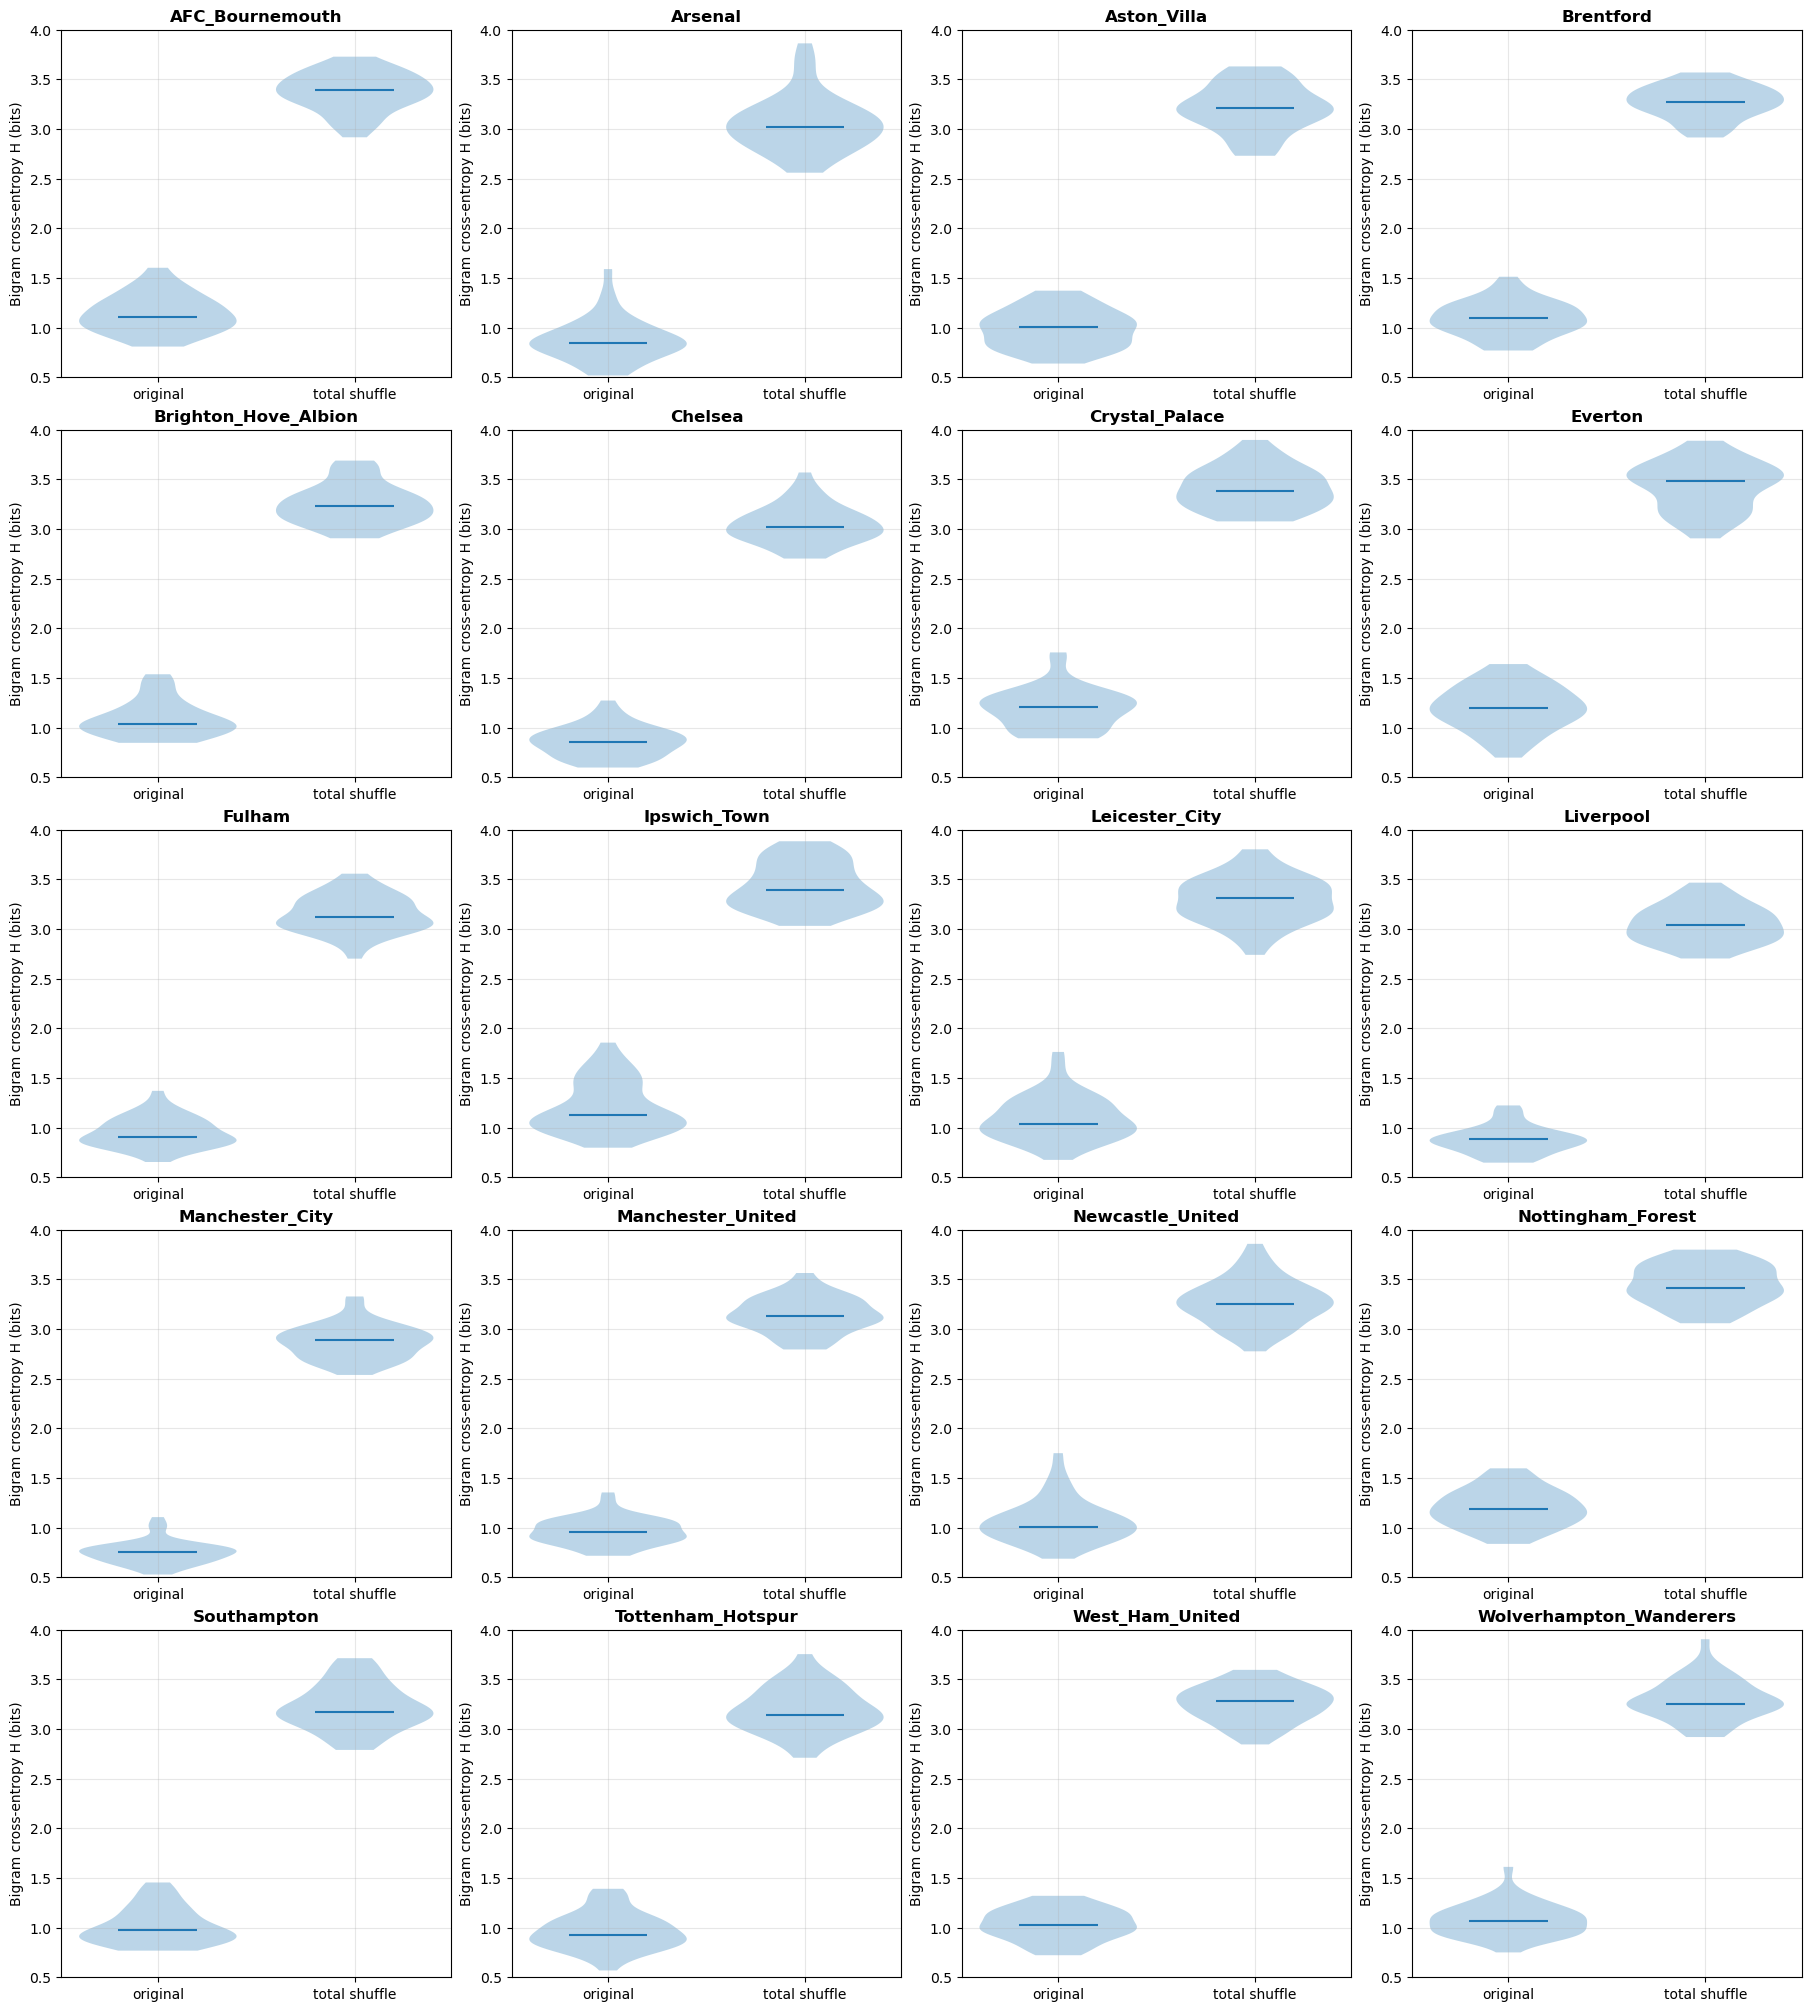

In [4]:
# ----------------------------
# CONFIG
# ----------------------------
# ----------------------------
# CONFIG
# ----------------------------
file_list = [
    "AFC_Bournemouth.csv",
    "Arsenal.csv",
    "Aston_Villa.csv",
    "Brentford.csv",
    "Brighton_Hove_Albion.csv",
    "Chelsea.csv",
    "Crystal_Palace.csv",
    "Everton.csv",
    "Fulham.csv",
    "Ipswich_Town.csv",
    "Leicester_City.csv",
    "Liverpool.csv",
    "Manchester_City.csv",
    "Manchester_United.csv",
    "Newcastle_United.csv",
    "Nottingham_Forest.csv",
    "Southampton.csv",
    "Tottenham_Hotspur.csv",
    "West_Ham_United.csv",
    "Wolverhampton_Wanderers.csv",
]

TEAM_PREFIXES = [Path(x).stem for x in file_list]
WORDS_COL = "words"
SEP = "-"

# Percorsi (Assicurati che siano corretti per il tuo ambiente)
ORIG_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Premier_League_24_25_texts"
SHUF_DIR = Path.home() / "Desktop" / "Podemi_and_Football-main" / "Linguistic" / "Premier_League_24_25_full_shuffle"

ALPHA = 0.5  # add-alpha smoothing (same as your earlier setting)

# ----------------------------
# Helpers: tokenize into phoneme bigrams (within-word)
# ----------------------------
def word_to_phonemes(word: str, sep: str = "-"):
    return [p.strip() for p in word.split(sep) if p.strip()]

def flatten_bigrams_from_words(words: np.ndarray, sep: str = "-"):
    bigrams = []
    unigrams = []
    for w in words:
        ph = word_to_phonemes(w, sep)
        unigrams.extend(ph)
        for i in range(len(ph) - 1):
            bigrams.append((ph[i], ph[i + 1]))
    return unigrams, bigrams

def read_words_column(csv_path: Path, col="words") -> np.ndarray:
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        try:
            df = pd.read_csv(csv_path, encoding="latin-1")
        except Exception:
            return np.array([], dtype=object)

    if col not in df.columns:
        return np.array([], dtype=object)

    s = df[col].dropna().astype(str).str.strip()
    s = s[s != ""]
    return s.to_numpy()

# ----------------------------
# Metric: Bigram cross-entropy H (bits)
# ----------------------------
def bigram_cross_entropy_bits(unigrams, bigrams, alpha=0.5):
    """
    Bigram model with add-alpha smoothing:
      P(y|x) = (c(x,y) + alpha) / (c(x) + alpha*|V|)
    Cross-entropy over observed bigrams:
      H = sum_{x,y} p_data(x,y) * [-log2 P(y|x)]
    """
    if len(bigrams) == 0:
        return np.nan

    uni = Counter(unigrams)
    bi = Counter(bigrams)
    V = len(uni)
    if V == 0:
        return np.nan

    total_b = sum(bi.values())
    H = 0.0
    for (x, y), cxy in bi.items():
        cx = uni[x]
        p_y_given_x = (cxy + alpha) / (cx + alpha * V)
        H += (cxy / total_b) * (-math.log2(p_y_given_x))
    return H

def H_for_match_file(csv_path: Path) -> float:
    words = read_words_column(csv_path, col=WORDS_COL)
    if len(words) == 0:
        return np.nan
    unigrams, bigrams = flatten_bigrams_from_words(words, sep=SEP)
    return bigram_cross_entropy_bits(unigrams, bigrams, alpha=ALPHA)

# ----------------------------
# Collect values per team
# ----------------------------
orig_files = [p for p in ORIG_DIR.iterdir() if p.is_file() and p.suffix.lower() == ".csv"] if ORIG_DIR.exists() else []
team_to_vals = {team: {"original": [], "total shuffle": []} for team in TEAM_PREFIXES}

all_H_values = []

for team in TEAM_PREFIXES:
    team_files = [p for p in orig_files if p.name == f"{team}.csv" or p.name.startswith(team + "_")]

    for p in team_files:
        shuf_p = SHUF_DIR / p.name
        if not shuf_p.exists():
            continue

        H_o = H_for_match_file(p)
        H_s = H_for_match_file(shuf_p)

        if np.isfinite(H_o):
            team_to_vals[team]["original"].append(H_o)
            all_H_values.append(H_o)
        if np.isfinite(H_s):
            team_to_vals[team]["total shuffle"].append(H_s)
            all_H_values.append(H_s)

# Global y-limits
if all_H_values:
    y_min = math.floor(min(all_H_values) * 2) / 2
    y_max = math.ceil(max(all_H_values) * 2) / 2
else:
    y_min, y_max = 0, 6

# ----------------------------
# Plot (5x4)
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(18, 20), constrained_layout=True)
axes = axes.ravel()

for i, team in enumerate(TEAM_PREFIXES):
    ax = axes[i]

    orig_vals = np.array(team_to_vals[team]["original"], dtype=float)
    shuf_vals = np.array(team_to_vals[team]["total shuffle"], dtype=float)

    orig_vals = orig_vals[np.isfinite(orig_vals)]
    shuf_vals = shuf_vals[np.isfinite(shuf_vals)]

    if len(orig_vals) > 0 and len(shuf_vals) > 0:
        ax.violinplot(
            [orig_vals, shuf_vals],
            positions=[1, 2],
            widths=0.8,
            showmedians=True,
            showextrema=False
        )
    else:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center", va="center")

    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    ax.set_title(f"{team}", fontweight="bold")
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["original", "total shuffle"])
    ax.set_ylabel("Bigram cross-entropy H (bits)")
    ax.grid(True, alpha=0.3)

for j in range(len(TEAM_PREFIXES), len(axes)):
    axes[j].axis("off")

plt.show()